In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
random.seed(42)

rock_mineral_properties = {
    "igneous_rocks": {
        "velocity_km_s": (5.4, 0.3),     # overlaps a bit with silicates, less with metamorphic
        "amplitude": (0.58, 0.05),
        "duration_ms": (230, 20)
    },
    "metamorphic_rocks": {
        "velocity_km_s": (6.3, 0.2),     # higher than igneous and others
        "amplitude": (0.72, 0.03),
        "duration_ms": (260, 15)
    },
    "sedimentary_rocks": {
        "velocity_km_s": (2.3, 0.2),     # clearly separated from others
        "amplitude": (0.38, 0.04),
        "duration_ms": (175, 15)
    },
    "ore_and_industrial_minerals": {
        "velocity_km_s": (4.2, 0.3),     # mid-range, slightly below silicates
        "amplitude": (0.52, 0.05),
        "duration_ms": (235, 20)
    },
    "silicate_minerals": {
        "velocity_km_s": (5.1, 0.2),     # near igneous, but tighter range
        "amplitude": (0.63, 0.04),
        "duration_ms": (290, 20)
    },
    "evaporites_and_soft_minerals": {
        "velocity_km_s": (1.7, 0.15),    # lowest velocity group
        "amplitude": (0.27, 0.02),
        "duration_ms": (145, 10)
    },
    "gem_and_rare_minerals": {
        "velocity_km_s": (6.9, 0.25),    # highest velocity and amplitude
        "amplitude": (0.83, 0.04),
        "duration_ms": (315, 20)
    }
}

# Dataset config
num_total_samples = 3000  # Slightly reduced to prevent synthetic bias
planet_name = "Earth"

# Prepare data containers
data = []
labels = []

all_classes = list(rock_mineral_properties.keys())
n_classes = len(all_classes)
samples_per_class = num_total_samples // n_classes

print(f"Generating ~{samples_per_class} samples for each of {n_classes} rock classes...")

# Generate samples per class
for rock_type in tqdm(all_classes, desc="Generating data"):
    props = rock_mineral_properties[rock_type]

    velocity = np.random.normal(loc=props['velocity_km_s'][0], scale=props['velocity_km_s'][1], size=samples_per_class)
    amplitude = np.random.normal(loc=props['amplitude'][0], scale=props['amplitude'][1], size=samples_per_class)
    duration = np.random.normal(loc=props['duration_ms'][0], scale=props['duration_ms'][1], size=samples_per_class)

    # Stack features
    features = np.stack([velocity, amplitude, duration], axis=1)

    # Add light correlated noise to simulate real-world imperfection
    noise = np.random.normal(loc=0, scale=0.05, size=features.shape)
    features += noise

    data.append(features)
    labels.extend([rock_type] * samples_per_class)

# Final assembly
data = np.vstack(data)
labels = np.array(labels)

# Shuffle the dataset to avoid order bias
indices = np.random.permutation(len(data))
data = data[indices]
labels = labels[indices]

# Build DataFrame
df = pd.DataFrame(data, columns=["velocity", "amplitude", "duration"])

print(df.head())
print(f"Final dataset shape: {df.shape}")
df.to_csv("Earth.csv", index=False)

Generating ~428 samples for each of 7 rock classes...


Generating data: 100%|██████████| 7/7 [00:00<00:00, 3204.90it/s]

   velocity  amplitude    duration
0  5.160272   0.672267  235.015949
1  5.585524   0.636524  218.924638
2  2.469896   0.476778  173.516833
3  6.047466   0.834514  250.579082
4  5.809222   0.478977  248.400343
Final dataset shape: (2996, 3)


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['material_encoded'] = le.fit_transform(df['material'])


In [ ]:
df.sample(4)

,velocity,amplitude,duration,material,planet,material_encoded
2992,2.786904,0.321121,175.906358,sedimentary_rocks,Earth,5
52884,2.733609,0.356102,156.283606,sedimentary_rocks,Earth,5
10294,2.621798,0.327098,184.984223,sedimentary_rocks,Earth,5
77708,4.110774,0.421429,212.290317,ore_and_industrial_minerals,Earth,4


In [ ]:
from sklearn.model_selection import train_test_split

X = df[['velocity', 'amplitude', 'duration']].values
y = df['material_encoded'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
len(np.unique(y))

7

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(3,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(le.classes_), activation='softmax')
])


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,567 (10.03 KB)

 Trainable params: 2,567 (10.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled,y_test),
    epochs=100,
    batch_size=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='accuracy',
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='accuracy',
            factor=0.001,
            patience=3,
            min_lr=1e-5
        )
    ],
    verbose=1
)


Epoch 1/100
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.7633 - loss: 0.6440 - val_accuracy: 0.9395 - val_loss: 0.1609 - learning_rate: 0.0010
Epoch 2/100
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.9203 - loss: 0.2116 - val_accuracy: 0.9379 - val_loss: 0.1613 - learning_rate: 0.0010
Epoch 3/100
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9247 - loss: 0.1987 - val_accuracy: 0.9382 - val_loss: 0.1622 - learning_rate: 0.0010
Epoch 4/100
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9304 - loss: 0.1869 - val_accuracy: 0.9477 - val_loss: 0.1402 - learning_rate: 0.0010
Epoch 5/100
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9323 - loss: 0.1814 - val_accuracy: 0.9423 - val_loss: 0.1545 - learning_rate: 0.0010
Epoch 6/100
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9330 - loss: 0.1795 - val_accuracy: 0.9480 - val_loss: 0.1422 - learning_rate: 0.0010
Epoch 7/100
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accura

In [ ]:
print("\n--- Evaluating the Model on Test Data ---")
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


--- Evaluating the Model on Test Data ---
Test Loss: 0.1358
Test Accuracy: 0.9496


In [ ]:
features = np.array([[2.61, 0.32, 175]])
input_data = np.array(features).reshape(1, -1)
predictions = model.predict(input_data)
pred_index = np.argmax(predictions[0])
class_name = le.inverse_transform([pred_index])[0]
print(class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
gem_and_rare_minerals


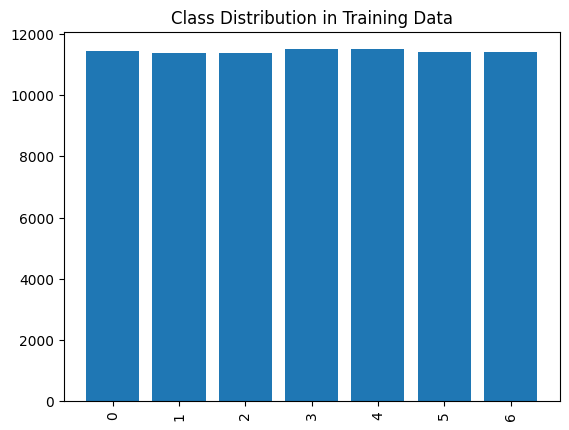

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.xticks(rotation=90)
plt.title("Class Distribution in Training Data")
plt.show()


In [ ]:
model_h5_path = 'rock-type-prediction-model.h5'
model.save(model_h5_path)
print(f"Model saved to: {model_h5_path}")

Model saved to: rock-type-prediction-model.h5


In [ ]:
igneous_rock_properties = {
    "Granite":     {"velocity": (4.6, 0.2), "temperature": (940, 30), "amplitude": (0.55, 0.03), "duration": (260, 15)},
    "Basalt":      {"velocity": (4.9, 0.1), "temperature": (980, 40), "amplitude": (0.65, 0.04), "duration": (240, 20)},
    "Rhyolite":    {"velocity": (4.3, 0.2), "temperature": (960, 50), "amplitude": (0.58, 0.05), "duration": (255, 18)},
    "Diorite":     {"velocity": (4.7, 0.15), "temperature": (935, 25), "amplitude": (0.56, 0.02), "duration": (250, 12)},
    "Obsidian":    {"velocity": (4.4, 0.25), "temperature": (970, 20), "amplitude": (0.60, 0.04), "duration": (235, 10)},
    "Pumice":      {"velocity": (4.1, 0.3), "temperature": (960, 60), "amplitude": (0.50, 0.06), "duration": (270, 25)},
    "Tuff":        {"velocity": (4.2, 0.3), "temperature": (950, 50), "amplitude": (0.52, 0.05), "duration": (265, 22)},
    "Andesite":    {"velocity": (4.5, 0.2), "temperature": (955, 40), "amplitude": (0.57, 0.04), "duration": (260, 20)},
    "Perlite":     {"velocity": (4.0, 0.25), "temperature": (930, 20), "amplitude": (0.48, 0.03), "duration": (275, 15)},
    "Anorthosite": {"velocity": (4.6, 0.15), "temperature": (945, 30), "amplitude": (0.54, 0.03), "duration": (250, 18)},
    "Peridotite":  {"velocity": (5.0, 0.2), "temperature": (990, 25), "amplitude": (0.66, 0.02), "duration": (235, 10)},
}

def generate_balanced_shuffled_igneous_dataset(properties_dict, samples_per_class=200, seed=42):
    np.random.seed(seed)
    all_samples = []

    for rock, stats in properties_dict.items():
        for _ in range(samples_per_class):
            velocity = np.random.normal(*stats["velocity"])
            temperature = np.random.normal(*stats["temperature"])
            amplitude = np.random.normal(*stats["amplitude"])
            duration = np.random.normal(*stats["duration"])
            all_samples.append({
                "rock_type": rock,
                "velocity": velocity,
                "temperature": temperature,
                "amplitude": amplitude,
                "duration": duration
            })

    df = pd.DataFrame(all_samples)
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)  # Shuffle
    return df

igneous_df = generate_balanced_shuffled_igneous_dataset(igneous_rock_properties, samples_per_class=300)


In [ ]:
print(igneous_df["rock_type"].value_counts())
print(igneous_df.head())

rock_type
Granite        300
Rhyolite       300
Obsidian       300
Andesite       300
Perlite        300
Tuff           300
Pumice         300
Basalt         300
Anorthosite    300
Diorite        300
Peridotite     300
Name: count, dtype: int64
  rock_type  velocity  temperature  amplitude    duration
0   Granite  4.703010  1055.581945   0.567127  277.033485
1  Rhyolite  4.425102  1004.261574   0.550382  257.223859
2  Obsidian  4.402196   965.246334   0.603064  229.882364
3  Andesite  4.453279   963.079960   0.550201  239.680091
4   Granite  4.889396   945.896643   0.580955  237.716594


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
import random

X_main = igneous_df[["velocity", "temperature", "amplitude", "duration"]]
y_main = igneous_df["rock_type"]

le_main = LabelEncoder()
y_main_encoded = le_main.fit_transform(y_main)

model1 = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, random_state=42))
model1.fit(X_main, y_main_encoded)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [ ]:
import math

def convert_mars_to_earth_features(mars_velocity, mars_amplitude, mars_duration, mars_temp):
    """
    Converts simulated physical features from a Martian environment to their
    Earth equivalents based on standard physics models.

    Assumptions:
    - Velocity is for an object falling from a fixed height (projectile motion).
    - Duration and Amplitude are related to the swing of a simple pendulum.
    - Temperature is a simplified conversion based on average surface temperatures.
    """
    # Gravitational constants (m/s²)
    EARTH_GRAVITY = 9.81
    MARS_GRAVITY = 3.71

    # --- Velocity Conversion (Based on Conservation of Energy) ---
    # For an object falling from the same height, v = sqrt(2*g*h).
    # This leads to the relationship: v_earth = v_mars * sqrt(g_earth / g_mars).
    # Your original exponent of 0.5 was correct for this model.
    earth_velocity = mars_velocity * math.sqrt(EARTH_GRAVITY / MARS_GRAVITY)

    # --- Duration Conversion (Based on a Simple Pendulum) ---
    # The period (T) of a pendulum is T = 2π * sqrt(L/g).
    # This means duration is inversely proportional to the square root of gravity.
    # The correct exponent is 0.5 (or sqrt), not 0.3.
    earth_duration = mars_duration * math.sqrt(MARS_GRAVITY / EARTH_GRAVITY)

    # --- Amplitude Conversion (Based on a Simple Pendulum) ---
    # For a pendulum swinging to the same angle, the linear amplitude (A)
    # would be the same. However, if we assume the same initial energy,
    # the amplitude would be inversely proportional to gravity.
    # A simpler, more direct relationship is often just an inverse of gravity.
    earth_amplitude = mars_amplitude * (MARS_GRAVITY / EARTH_GRAVITY)

    # --- Temperature Conversion (Simplified Offset) ---
    # Clamping is not a conversion. This is a simple offset conversion based on the
    # approximate difference in average temperatures (Earth: ~14°C, Mars: ~-63°C).
    # This is a much more physically meaningful, though simplified, conversion.
    # The difference is approximately 77°C.
    earth_temp = mars_temp + 77.0

    return [earth_velocity, earth_amplitude, earth_duration, earth_temp]

In [ ]:
mars_sample = [
    {"velocity": 4.58, "amplitude": 0.62, "duration": 241.93, "temp": 986.12 },
    {"velocity": 5.39, "amplitude": 0.68, "duration": 309.75, "temp": 856.34}
]

for i, sample in enumerate(mars_sample):
    conv = convert_mars_to_earth_features(sample['velocity'], sample['amplitude'], sample['duration'], sample['temp'])
    print(f"Mars Sample {i+1} converted to Earth features: {conv}")


# Convert all Mars samples to Earth domain
earth_inputs = [convert_mars_to_earth_features(
    sample["velocity"], sample["amplitude"], sample["duration"], sample["temp"]
) for sample in mars_sample]

# Scale inputs using fitted Earth scaler
earth_inputs_scaled = scaler.transform(earth_inputs)

# Predict with trained model
predictions = model.predict(earth_inputs_scaled)
pred_indices = np.argmax(predictions, axis=1)
predicted_labels = le.inverse_transform(pred_indices)

# Output
for i, label in enumerate(predicted_labels):
    print(f"Mars Sample {i+1} → Predicted Earth Material: {label}")


Mars Sample 1 converted to Earth features: [7.447543128595571, 0.2344750254841998, 148.77918541291479, 1063.12]
Mars Sample 2 converted to Earth features: [8.76468503561793, 0.25716615698267076, 190.48630877382033, 933.34]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Mars Sample 1 → Predicted Earth Material: igneous_rocks
Mars Sample 2 → Predicted Earth Material: silicate_minerals


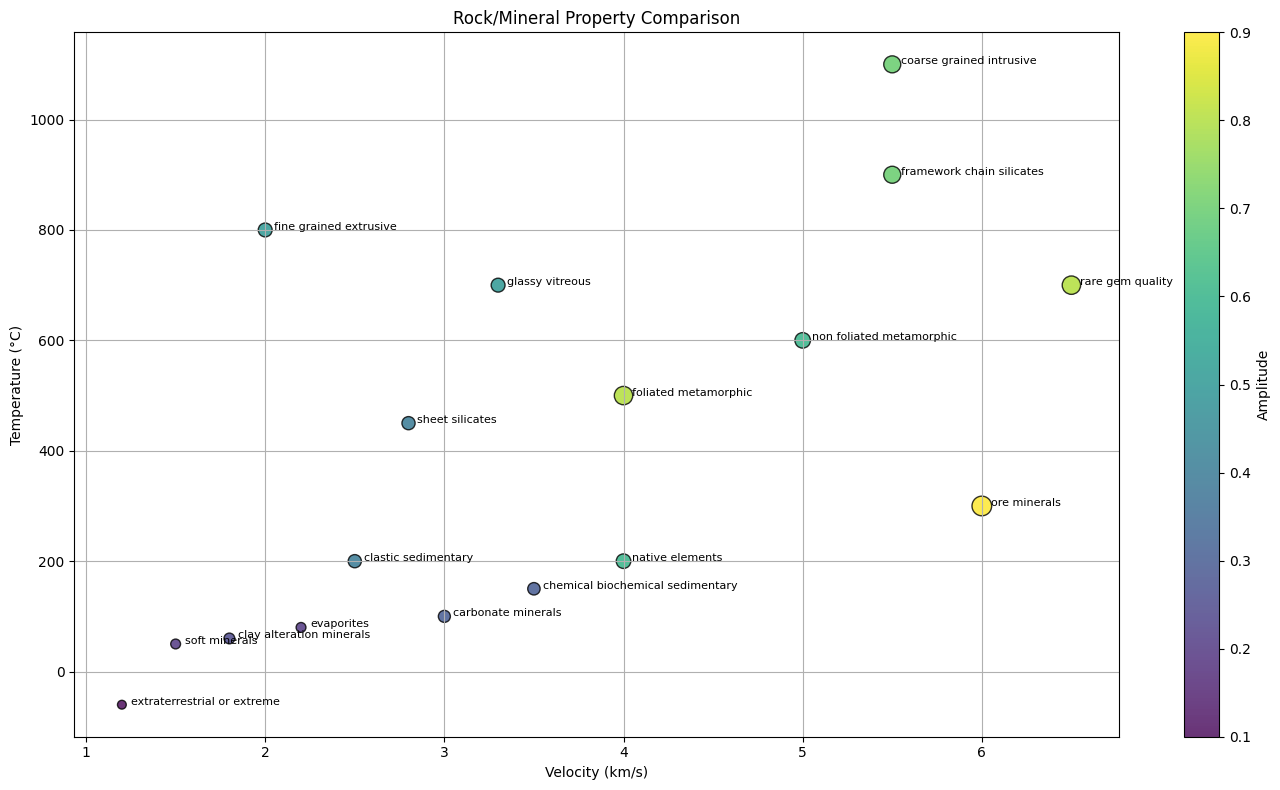

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your input dictionary
rock_mineral_properties = {
    "fine_grained_extrusive": {
        "velocity_km_s": 2.0, "temperature_C": 800, "amplitude": 0.5, "duration_ms": 200
    },
    "coarse_grained_intrusive": {
        "velocity_km_s": 5.5, "temperature_C": 1100, "amplitude": 0.7, "duration_ms": 300
    },
    "foliated_metamorphic": {
        "velocity_km_s": 4.0, "temperature_C": 500, "amplitude": 0.8, "duration_ms": 350
    },
    "non_foliated_metamorphic": {
        "velocity_km_s": 5.0, "temperature_C": 600, "amplitude": 0.6, "duration_ms": 250
    },
    "clastic_sedimentary": {
        "velocity_km_s": 2.5, "temperature_C": 200, "amplitude": 0.4, "duration_ms": 180
    },
    "chemical_biochemical_sedimentary": {
        "velocity_km_s": 3.5, "temperature_C": 150, "amplitude": 0.3, "duration_ms": 160
    },
    "evaporites": {
        "velocity_km_s": 2.2, "temperature_C": 80, "amplitude": 0.2, "duration_ms": 100
    },
    "ore_minerals": {
        "velocity_km_s": 6.0, "temperature_C": 300, "amplitude": 0.9, "duration_ms": 400
    },
    "glassy_vitreous": {
        "velocity_km_s": 3.3, "temperature_C": 700, "amplitude": 0.5, "duration_ms": 200
    },
    "soft_minerals": {
        "velocity_km_s": 1.5, "temperature_C": 50, "amplitude": 0.2, "duration_ms": 100
    },
    "sheet_silicates": {
        "velocity_km_s": 2.8, "temperature_C": 450, "amplitude": 0.4, "duration_ms": 180
    },
    "framework_chain_silicates": {
        "velocity_km_s": 5.5, "temperature_C": 900, "amplitude": 0.7, "duration_ms": 300
    },
    "carbonate_minerals": {
        "velocity_km_s": 3.0, "temperature_C": 100, "amplitude": 0.3, "duration_ms": 150
    },
    "native_elements": {
        "velocity_km_s": 4.0, "temperature_C": 200, "amplitude": 0.6, "duration_ms": 220
    },
    "rare_gem_quality": {
        "velocity_km_s": 6.5, "temperature_C": 700, "amplitude": 0.8, "duration_ms": 350
    },
    "clay_alteration_minerals": {
        "velocity_km_s": 1.8, "temperature_C": 60, "amplitude": 0.25, "duration_ms": 120
    },
    "extraterrestrial_or_extreme": {
        "velocity_km_s": 1.2, "temperature_C": -60, "amplitude": 0.1, "duration_ms": 80
    }
}

# Convert to plottable lists
categories = []
velocity = []
temperature = []
amplitude = []
duration = []

for cat, props in rock_mineral_properties.items():
    categories.append(cat)
    velocity.append(props["velocity_km_s"])
    temperature.append(props["temperature_C"])
    amplitude.append(props["amplitude"])
    duration.append(props["duration_ms"])

# Plotting
plt.figure(figsize=(14, 8))
scatter = plt.scatter(
    velocity, temperature,
    c=amplitude, s=[d / 2 for d in duration],
    cmap='viridis', alpha=0.8, edgecolors='k'
)

# Add labels
for i, cat in enumerate(categories):
    plt.text(velocity[i]+0.05, temperature[i], cat.replace('_', ' '), fontsize=8)

plt.title("Rock/Mineral Property Comparison")
plt.xlabel("Velocity (km/s)")
plt.ylabel("Temperature (°C)")
cbar = plt.colorbar(scatter)
cbar.set_label("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()
